## Predicting Survival on the Titanic

### History
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

### Assignment:

Build a Machine Learning Pipeline, to engineer the features in the data set and predict who is more likely to Survive the catastrophe.

Follow the Jupyter notebook below, and complete the missing bits of code, to achieve each one of the pipeline steps.

In [1]:
import re

# to handle datasets
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler

# to build the models
from sklearn.linear_model import LogisticRegression

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score

# to persist the model and the scaler
import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

## Prepare the data set

In [2]:
# load the data - it is available open source and online

data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')
# display data
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


In [3]:
# replace interrogation marks by NaN Values
data = data.replace('?', np.nan)

In [4]:
# retain only the first cabin if more than
# 1 are available per passenger

def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan

data['cabin'] = data['cabin'].apply(get_first_cabin)


In [5]:
# extracts the title (Mr, Ms, etc) from the name variable

def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master',line):
        return 'Master'
    else:
        return 'Other'

data['title'] = data['name'].apply(get_title)


In [6]:
# cast numerical variables as floats

data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')

In [7]:
# drop unnecessary variables

data.drop(labels=['name','ticket', 'boat', 'body','home.dest'], axis=1, inplace=True)

# display data
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


In [8]:
# save the data set
data.to_csv('titanic.csv', index=False)

## Data Exploration

### Find numerical and categorical variables

In [9]:
target='survived'

In [10]:
# make list of numerical variables
vars_num = [var for var in data.columns if data[var].dtypes !='O' and var !=target]

# make list of categorucal variabels
vars_cat = [var for var in data.columns if data[var].dtypes =='O']

print('Number of numerical variables: {}'.format(len(vars_num)))
print('Number of categorical variables: {}'.format(len(vars_cat)))

Number of numerical variables: 5
Number of categorical variables: 4


### Find missing values in variables

In [11]:
# first in numerical variables
data[vars_num].isnull().mean()

pclass    0.000000
age       0.200917
sibsp     0.000000
parch     0.000000
fare      0.000764
dtype: float64

In [12]:
# now in categorical variables
data[vars_cat].isnull().mean()

sex         0.000000
cabin       0.774637
embarked    0.001528
title       0.000000
dtype: float64

### Determine cardinality of categorical variables

In [13]:
# evaluate how many different categories in each variables
data[vars_cat].nunique()

sex           2
cabin       181
embarked      3
title         5
dtype: int64

All the categorical variables show low cardinality except for cabin.

### Determine the distribution of numerical variables

In [14]:
# first make discrete variable list
discrete_vars = [var for var in vars_num if len(
    data[var].unique()) < 20 and var !='survived']

print('Number of discrete variables: ', len(discrete_vars))

Number of discrete variables:  3


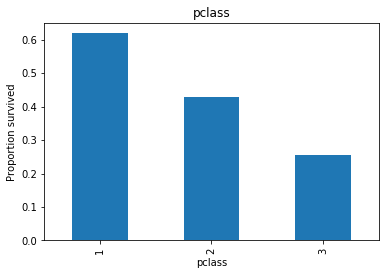

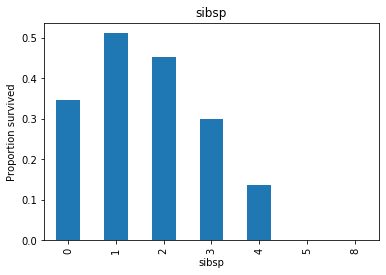

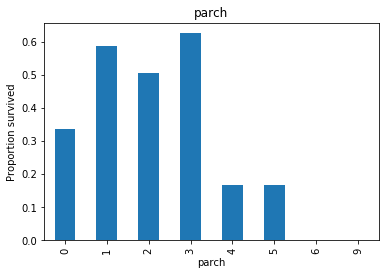

In [15]:
# analyse discrete variable to survive proportion 
def analyse_discrete (df, var):
    df = df.copy()
    df.groupby(var)['survived'].mean().plot.bar()
    plt.title(var)
    plt.ylabel('Proportion survived')
    plt.show()

for var in discrete_vars:
    analyse_discrete(data,var)

Numbers of continouse variables:  2


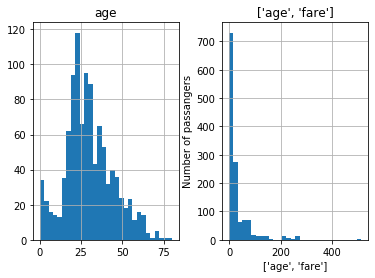

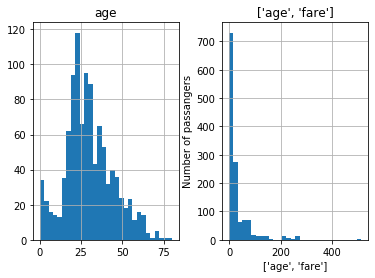

In [16]:
# make list of continuous variabel
cont_vars = [var for var in vars_num if var not in discrete_vars+['survived']]
print('Numbers of continouse variables: ',len(cont_vars))

# analyse the distribution of continous variables
def analyse_countinous (df, var):
    df = df.copy()
    df[var].hist(bins=30)
    plt.ylabel('Number of passangers')
    plt.xlabel(var)
    plt.title(var)
    plt.show()
    
for var in cont_vars:
    analyse_countinous(data,cont_vars)

Age and fare is not normally distributed

## Separate data into train and test

Use the code below for reproducibility. Don't change it.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1047, 9), (262, 9))

In [18]:
X_train.head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title
1118,3,male,25.0,0,0,7.9250,NaN,S,Mr
44,1,female,41.0,0,0,134.5000,E40,C,Miss
1072,3,male,NaN,0,0,7.7333,NaN,Q,Mr
1130,3,female,18.0,0,0,7.7750,NaN,S,Miss
574,2,male,29.0,1,0,21.0000,NaN,S,Mr


## Feature Engineering

### Extract only the letter (and drop the number) from the variable Cabin

In [19]:
def number_out(row):
    try:
        return re.sub("\d+","",row)
    except:
        return np.nan

data['cabin'] = data['cabin'].apply(number_out)
data['cabin'].unique()

array(['B', 'C', 'E', 'D', 'A', nan, 'T', 'F', 'G'], dtype=object)

In [20]:
X_train.columns

Index(['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'cabin', 'embarked',
       'title'],
      dtype='object')

### Fill in Missing data in numerical variables:

- Add a binary missing indicator
- Fill NA in original variable with the median

In [21]:
# make list of numerical variables that contains missing values
num_vars_with_na = [
    var for var in X_train.columns
    if X_train[var].isnull().sum()>0 and X_train[var].dtypes !='O'
    and var not in 'survived' #there is no missing values on target columns, according to previous step
]

# print percentage of missing value per variables
#X_train[vars_with_na].isnull().mean()

#replace engineer missing values 

for var in num_vars_with_na:
    #calculate the median using train set data
    median_val = X_train[var].median()
    
    #add binary missing indicator in both train and test data
    X_train[var+'_na'] = np.where(X_train[var].isnull(),1,0)
    X_test[var+'_na'] = np.where(X_test[var].isnull(),1,0)
    
    # replace missing values on both train and set with median values
    X_train[var] = X_train[var].fillna(median_val)
    X_test[var] = X_test[var].fillna(median_val)

#check that there no missing data after, 
X_train[num_vars_with_na].isnull().sum()

age     0
fare    0
dtype: int64

### Replace Missing data in categorical variables with the string **Missing**

In [22]:
# make list of categorical variables that contains missing values
cat_vars_with_na =[
    var for var in X_train.columns
    if X_train[var].isnull().sum()>0 and X_train[var].dtypes =='O'
]

# replace missing values with the new label :'missing'
X_train[cat_vars_with_na] = X_train[cat_vars_with_na].fillna('Missing')
X_test[cat_vars_with_na] = X_test[cat_vars_with_na].fillna('Miising')

#check that there no missing data after replaced
X_train[cat_vars_with_na].isnull().sum()

cabin       0
embarked    0
dtype: int64

### Remove rare labels in categorical variables

- remove labels present in less than 5 % of the passengers

In [23]:
#create function to find the label that are shared by more
#that a certain % of the target in dataset

def find_frequent_labels(df, var, rare_pct):
    df = df.copy()
    
    tmp = df.groupby(var)['pclass'].count()/len(df) #counting number of rows
    return tmp[tmp>rare_pct].index


for var in vars_cat:
    #find the frequent categories
    frequent_ls = find_frequent_labels(X_train,var, 0.05)
    
    # replace the rare categories by string 'Rare'
    X_train[var] = np.where(X_train[var].isin(frequent_ls), X_train[var],'Rare')
    X_test[var] = np.where(X_test[var].isin(frequent_ls), X_test[var],'Rare')
    

In [24]:
X_train.head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,age_na,fare_na
1118,3,male,25.0,0,0,7.9250,Missing,S,Mr,0,0
44,1,female,41.0,0,0,134.5000,Rare,C,Miss,0,0
1072,3,male,28.0,0,0,7.7333,Missing,Q,Mr,1,0
1130,3,female,18.0,0,0,7.7750,Missing,S,Miss,0,0
574,2,male,29.0,1,0,21.0000,Missing,S,Mr,0,0


In [25]:
X_test.head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,age_na,fare_na
1139,3,male,38.0,0,0,7.8958,Rare,S,Mr,0,0
533,2,female,21.0,0,1,21.0000,Rare,S,Miss,0,0
459,2,male,42.0,1,0,27.0000,Rare,S,Mr,0,0
1150,3,male,28.0,0,0,14.5000,Rare,S,Mr,1,0
393,2,male,25.0,0,0,31.5000,Rare,S,Mr,0,0


### Perform one hot encoding of categorical variables into k-1 binary variables

- k-1, means that if the variable contains 9 different categories, we create 8 different binary variables
- Remember to drop the original categorical variable (the one with the strings) after the encoding

In [26]:
# this function will assign discrete values to string of the variables
# so that the smaller values corresponds to the category that shows the smaller
# mean 'survived'?

def replace_categories(train, test, var, target):
    # order the categories in a variable from that with 0 to 1
    # survived status
    ordered_labels = train.groupby([var])[target].mean().sort_values().index
    
    # create dictionary of ordered categories to integer values
    ordinal_label = {k: i for i, k in enumerate (ordered_labels,0)}
    
    # use the dictionary to replace the categorical string by integers
    train[var] = train[var].map(ordinal_label)
    test[var] = test[var].map(ordinal_label)

In [27]:
for var in vars_cat:
    replace_categories(X_train,X_test,var,'pclass')

In [28]:
X_train.head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,age_na,fare_na
1118,3,1,25.0,0,0,7.9250,1,2,3,0,0
44,1,0,41.0,0,0,134.5000,0,1,2,0,0
1072,3,1,28.0,0,0,7.7333,1,3,3,1,0
1130,3,0,18.0,0,0,7.7750,1,2,2,0,0
574,2,1,29.0,1,0,21.0000,1,2,3,0,0


### Scale the variables

- Use the standard scaler from Scikit-learn

In [29]:
# capture all variables in a list
# except the age_na, fare_na, survived

#train_vars = [var for var in X_train.columns if var not in ['age_na', 'fare_na','survived']]

# create scaler
scaler = StandardScaler()

# fit the scaler to the train set
# scaler.fit(X_train[train_vars])

# # transform the train and test set
# X_train[train_vars] = scaler.transform(X_train[train_vars])

# X_test[train_vars] = scaler.transform(X_test[train_vars])

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Train the Logistic Regression model

- Set the regularization parameter to 0.0005
- Set the seed to 0

In [30]:
# set up the model
# set random seed =0

# drop uneccesary variables
# X_train = X_train[train_vars]
# X_test = X_test[train_vars]

logis_mod = LogisticRegression(random_state=0, C=0.0005)

# train model
logis_mod.fit(X_train,y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.0005, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

## Make predictions and evaluate model performance

Determine:
- roc-auc
- accuracy

**Important, remember that to determine the accuracy, you need the outcome 0, 1, referring to survived or not. But to determine the roc-auc you need the probability of survival.**

In [31]:
# make prediction for train set
pred = logis_mod.predict(X_train)
prob = logis_mod.predict_proba(X_train)[:,1]

#determine accuracy and roc-auc for training
print('train accuracy:{}'.format(
    accuracy_score(y_train,pred)))

print('train roc-auc:{}'.format(
    roc_auc_score(y_train,prob)
    ))

# make prediction for test set
pred = logis_mod.predict(X_test)
prob = logis_mod.predict_proba(X_test)[:,1]


# determine accuracy and roc-auc for test
print('test accuracy:{}'.format(
    accuracy_score(y_test,pred)))

print('test roc-auc:{}'.format(
    roc_auc_score(y_test,prob)))

train accuracy:0.7707736389684814
train roc-auc:0.8343276661514684
test accuracy:0.7786259541984732
test roc-auc:0.8300308641975308


### Try to submit on kaggle


In [32]:
kaggle_test = pd.read_csv('test_kaggle.csv')

# treat same preparation for data 

# replace interrogation marks by NaN Values
kaggle_test = kaggle_test.replace('?', np.nan)

# retaion only first cabin
kaggle_test['Cabin'] = kaggle_test['Cabin'].apply(get_first_cabin)

# extract title
kaggle_test['title'] = kaggle_test['Name'].apply(get_title)

# cast numerical variables as floats
kaggle_test['Fare'] = kaggle_test['Fare'].astype('float')
kaggle_test['Age'] = kaggle_test['Age'].astype('float')

# drop unnecessary variables
kaggle_test.drop(labels=['Name'], axis=1, inplace=True)

# extract letter
kaggle_test['Cabin'] = kaggle_test['Cabin'].apply(number_out)


# make list of numerical variables that contains missing values
num_vars_with_na = [
    var for var in kaggle_test.columns
    if kaggle_test[var].isnull().sum()>0 and kaggle_test[var].dtypes !='O'
    and var not in 'survived' #there is no missing values on target columns, according to previous step
]

#replace engineer missing values 
for var in num_vars_with_na:
    #calculate the median using train set data
    median_val = kaggle_test[var].median()
    
    #add binary missing indicator in both train and test data
    kaggle_test[var+'_na'] = np.where(kaggle_test[var].isnull(),1,0)
    
    # replace missing values on both train and set with median values
    kaggle_test[var] = kaggle_test[var].fillna(median_val)

# make list of categorical variables that contains missing values
cat_vars_with_na =[
    var for var in kaggle_test.columns
    if kaggle_test[var].isnull().sum()>0 and kaggle_test[var].dtypes =='O'
]

# replace missing values with the new label :'missing'
kaggle_test[cat_vars_with_na] = kaggle_test[cat_vars_with_na].fillna('Missing')

#create function to find the label that are shared by more
#that a certain % of the target in dataset
def find_frequent_labels(df, var, rare_pct):
    df = df.copy()
    
    tmp = df.groupby(var)['Pclass'].count()/len(df) #counting number of rows
    return tmp[tmp>rare_pct].index

vars_cat = [var for var in kaggle_test.columns if kaggle_test[var].dtypes =='O']

for var in vars_cat:
    #find the frequent categories
    frequent_ls = find_frequent_labels(kaggle_test,var, 0.05)
    
    # replace the rare categories by string 'Rare'
    kaggle_test[var] = np.where(kaggle_test[var].isin(frequent_ls), kaggle_test[var],'Rare')
    
    
def replace_categories(kaggle_test, var, target):
    # order the categories in a variable from that with 0 to 1
    # survived status
    ordered_labels = kaggle_test.groupby([var])[target].mean().sort_values().index
    
    # create dictionary of ordered categories to integer values
    ordinal_label = {k: i for i, k in enumerate (ordered_labels,0)}
    
    # use the dictionary to replace the categorical string by integers
    kaggle_test[var] = kaggle_test[var].map(ordinal_label)

for var in vars_cat:
    replace_categories(kaggle_test, var,'Pclass')

    
passid = kaggle_test['PassengerId']
kaggle_test.drop(labels=['PassengerId','Ticket'], axis=1, inplace=True)
scaler.fit(kaggle_test)
kaggle_test = scaler.transform(kaggle_test)

# make prediction for train set

predictions = logis_mod.predict(kaggle_test)

submission = pd.DataFrame({ 'PassengerId' : passid, 'Survived': predictions })
submission.to_csv('submission.csv', index=False)


That's it! Well done

**Keep this code safe, as we will use this notebook later on, to build production code, in our next assignement!!**